In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

#MODELOS
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import SimpleRNN as RNN

#metricas
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error
# Evitar overffiting
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout



In [2]:
from pre_process import model_input

## LInks interessantes:[
  https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/

In [23]:
data_health = pd.read_csv('saude.csv')
dir=''

In [27]:
from google.colab import drive
drive.mount('/content/drive')
dir = '/content/drive/Shareddrives/TCC_PES/codigos/'

data_health = pd.read_csv(dir+'saude.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importando os dados já processados

In [24]:
data_health = data_health.groupby(by=['COD_FALH','COD_AENV','DT_PROC']).median().reset_index()
data_health['id']=data_health.index
data_health.head()

np.random.seed(123)
np.random.randint(0,2,10)
teste = np.random.choice(np.unique(data_health.COD_AENV),2)
print("Aviões usados para teste: ", teste)

data_health  = data_health[data_health.COD_AENV != teste[0]][data_health.COD_AENV != teste[1]]
np.unique(data_health.COD_AENV)

Aviões usados para teste:  [9834 9747]


c:\Users\CepaTech\Documents\Miniconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


array([1011, 9486, 9526, 9636, 9664, 9678, 9770, 9793], dtype=int64)

In [7]:
def metrics_(testY,testPredict):
  # testPredict = model.predict(testX)
  y_true = testY[:,0]*100
  y_pred = testPredict*100

  mse  = mean_squared_error(y_true, y_pred) 
  rmse = mean_squared_error(y_true, y_pred, squared = False)
  max_e =  max_error(y_true, y_pred) 
  mae = mean_absolute_error(y_true, y_pred)
  r2 = r2_score(y_true, y_pred)

  return([mse, rmse, max_e, mae,r2])

In [10]:
def data_func (train_test, aenv,l_train):
  
  sample = l_train+10
  y_index = l_train+9
  
  trainX = train_test[train_test[:,sample]!=aenv][:,:l_train]/100
  trainY = train_test[train_test[:,sample]!=aenv][:,y_index]/100
  trainX = np.reshape(trainX, (trainX.shape[0],1, trainX[0].shape[0]))
  trainY = np.reshape(trainY, (trainY.shape[0],1, 1))

  testX = train_test[train_test[:,sample]==aenv][:,:l_train]/100
  testY = train_test[train_test[:,sample]==aenv][:,y_index]/100
  testX  = np.reshape(testX , (testX.shape[0], 1, testX[0].shape[0]))
  testY = np.reshape(testY, (testY.shape[0], 1,1))

  return trainX, trainY, testX, testY


def plot_results():
  trainPredict = model.predict(trainX)
  testPredict = model.predict(testX)

  print("Aeronave: "+ str(int(aenv))+ "   " +name)

  plt.figure(dpi=100,figsize=(20,5))
  plt.plot(testY[:,0]*100,':ok')
  plt.plot(testPredict[:,0]*100,'-xm')
  plt.title("Aeronave: "+ str(int(aenv)))
  plt.xlabel("Dias")
  plt.ylabel("Desgaste")
  plt.legend(["Esperado",'Predito'])
  

In [8]:
def recorrent_model (name,units=5,look_back=20):
  model = Sequential()
  if name == "LSTM":
      model.add(LSTM(units, input_shape=(1, look_back)))
  elif name=="GRU":
      model.add(GRU(units, input_shape=(1, look_back)))
  elif name == "RNN":
      model.add(RNN(units, input_shape=(1, look_back)))
  else:
      print("Model not found")

  # model.add(Dropout(0.2))
  model.add(Dense(1))

  return model

In [ ]:
# create and fit the LSTM network] [mse, rmse, max_e, mae,r2]
data_results = pd.DataFrame([],columns=['MSE', 'RMSE',  'MaxE', 'MAE', "R2",'AENV','Modelo','Parâmetros','MOD_FALH',"JANELA"])
aenvs =np.unique(data_health.COD_AENV)
for falh in [1,23,24]:
  for look_back in [5,10,15,20,25,30]:
    train_test = model_input(data_health, l_train=look_back,falh = falh)

    for name in ["RNN","GRU","LSTM"]:
      results = []
      for k in range(0,8):
        tf.random.set_seed(7)
        aenv=aenvs[k]

        trainX, trainY, testX, testY = data_func(train_test, aenv,look_back)

        model = recorrent_model(name=name,units=10,look_back=look_back)
        early_stopping = EarlyStopping(patience=5)
        model.compile(loss='mean_squared_error', val_loss='mean_squared_error', optimizer='adam')
        model.fit(trainX, trainY, epochs=100, batch_size=10, validation_split=0.2, callbacks=[early_stopping], verbose=0)

        
        result = metrics_(testY,model.predict(testX))
        result.append(int(aenv))
        result.append(name)
        result.append(model.count_params())
        result.append(falh)
        result.append(look_back)
        
        results.append(result)
        print(result)

      print()
      data_results = pd.concat([data_results, pd.DataFrame(results,columns=['MSE', 'RMSE',  'MaxE', 'MAE', "R2",'AENV','Modelo','Parâmetros','MOD_FALH',"JANELA"])])

data_results.to_csv(dir+'resultados/resul_all.csv')

In [20]:
train_test[0]

array([  56.62153783,   56.69455016,   56.3900003 ,   56.6013845 ,
         56.67430367,   56.99680381,   56.49680697,   56.83107865,
         56.56471672,   56.92600035,   56.96841643,   56.99985241,
         56.80706238,   56.80921612,   57.09983723,   57.24573646,
         57.06752896,   57.45485531,   56.95345481,   57.162485  ,
         56.99545962,   57.29815683,   56.29546342,   57.43812296,
         57.07873948,   57.42613271,   57.05762853,   57.04159534,
         57.2757735 ,   57.32751608, 1011.        ])

### Visualizando os resultados 

In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
results = pd.read_csv('resultados/resul_all.csv', index_col=0)

In [3]:


colors1 = [    
          (15/255,114/255,255/255,1), # blue 
          (224/255,0/255,193/255,.88), #pink
          (1.0, 0.807843137254902, 0.0392156862745098, 1), #orange
          (0.95, 0, 0, 1), #red
          (0, 0.6666666666666666, 0.6274509803921569, 1), #green
          
          (0, 0.9764705882352941, 0, 0.5), #       
          (10/255,10/255, 130/255, 1), #(0.4, 0.0, 0.6, 1), # green
          (0.6, 0/255, 0.4, 0.8)#
        ]

In [110]:
import plotly.express as px
px.line(results[results.MOD_FALH==1],x="JANELA", y="RMSE", color="Modelo")

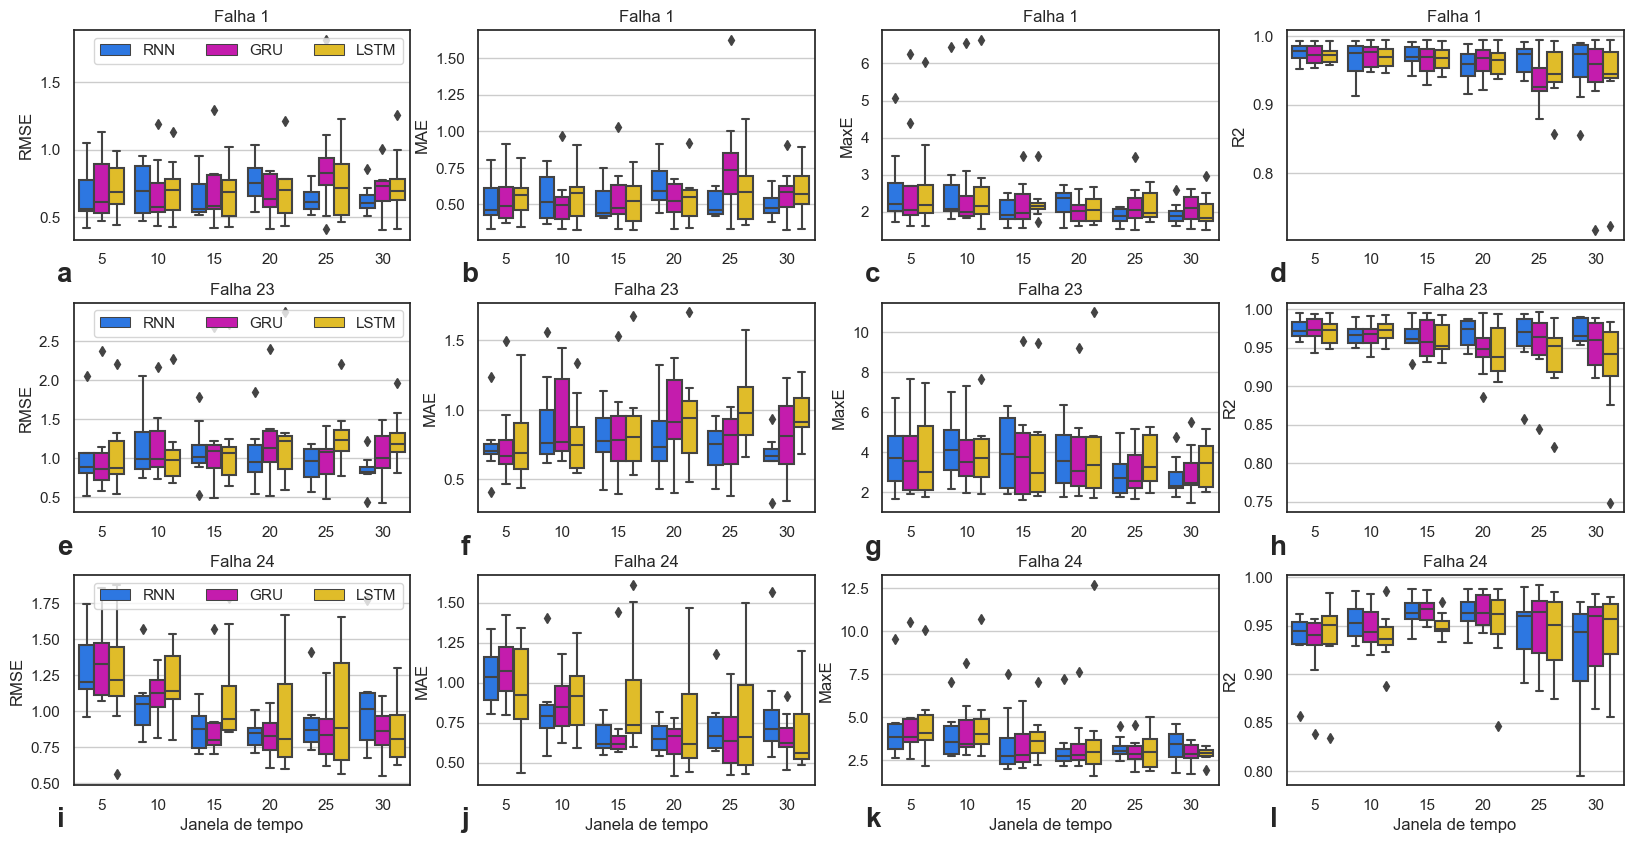

In [5]:
falhs = np.unique(results.MOD_FALH)
metrics =  ['RMSE','MAE','MaxE','R2']
sns.set_theme(style="white", palette=None)
fig = plt.figure(figsize = (20,10),dpi=100)
axes = gridspec.GridSpec(nrows=3, ncols=4, figure=fig, wspace=0.2, hspace=0.3)

r = [0,0,0,0,1,1,1,1,2,2,2,2]
c = [0,1,2,3,0,1,2,3,0,1,2,3]

im = ['a','b','c','d','e','f','g','h','i','j','k','l']
count=0
for falh in falhs:
    for metric in metrics:
        ax = fig.add_subplot(axes[r[count],c[count]])
        ax.grid()
        sns.boxplot(x="JANELA", y=metric, hue="Modelo", data=results[results.MOD_FALH==falh], palette=colors1)
        ax.text(-0.05, -0.2, im[count], size=20, weight='bold', transform=ax.transAxes)
        ax.set_title('Falha '+str(falh))
        if count in [0,4,8]:
            ax.legend(loc='upper right', ncol=3)
        else:
            ax.legend(loc='upper right', ncol=3).remove()
        

        if (count>7):
            ax.set_xlabel('Janela de tempo')
        else:
            ax.set_xlabel('')
        count+=1


In [112]:
#Selecionando os melhores modelos para cada falha
results_=results.groupby(['Modelo','MOD_FALH','JANELA']).mean().reset_index()
results_.groupby(['MOD_FALH']).apply(lambda x: x[x['RMSE'] == x['RMSE'].min()]).reset_index(drop=True)

,Modelo,MOD_FALH,JANELA,MSE,RMSE,MaxE,MAE,R2,AENV,Parâmetros
0,RNN,1,30,0.408004,0.629896,1.940732,0.497910,0.953905,8570.5,421.0
1,RNN,23,30,0.755276,0.845447,2.760303,0.666398,0.970340,8570.5,421.0
2,GRU,24,20,0.690188,0.818396,3.509032,0.629511,0.964836,8570.5,971.0


### Melhor modelo

Aeronave: 1011   GRU
Aeronave: 9486   GRU
Aeronave: 9526   GRU
Aeronave: 9636   GRU
Aeronave: 9664   GRU
Aeronave: 9678   GRU
Aeronave: 9770   GRU
Aeronave: 9793   GRU


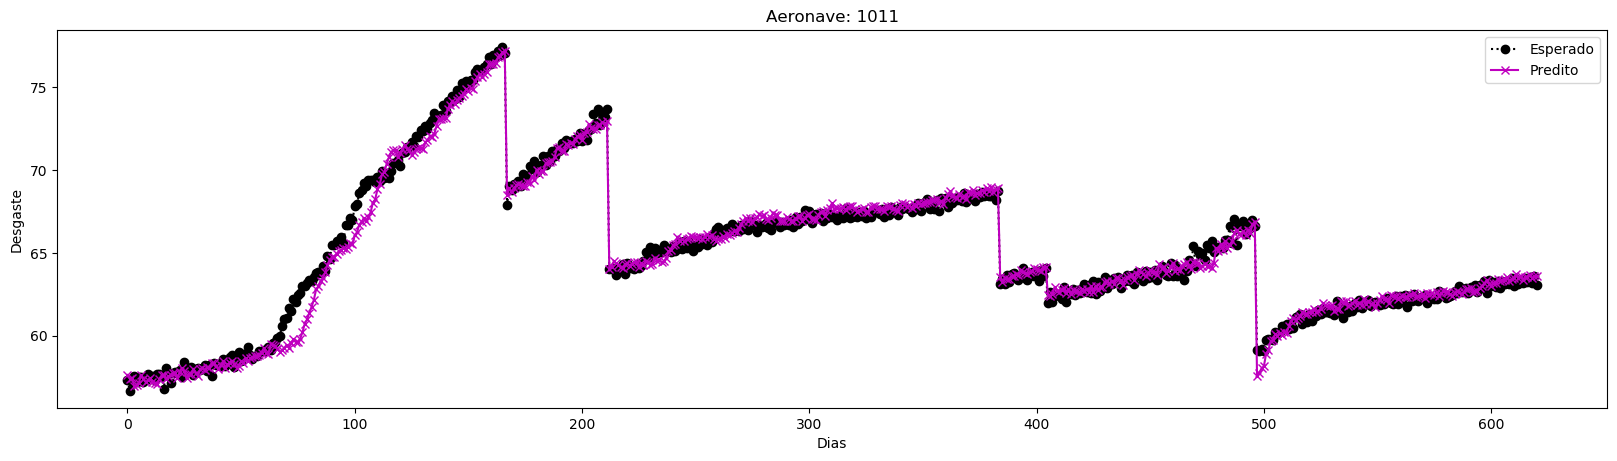

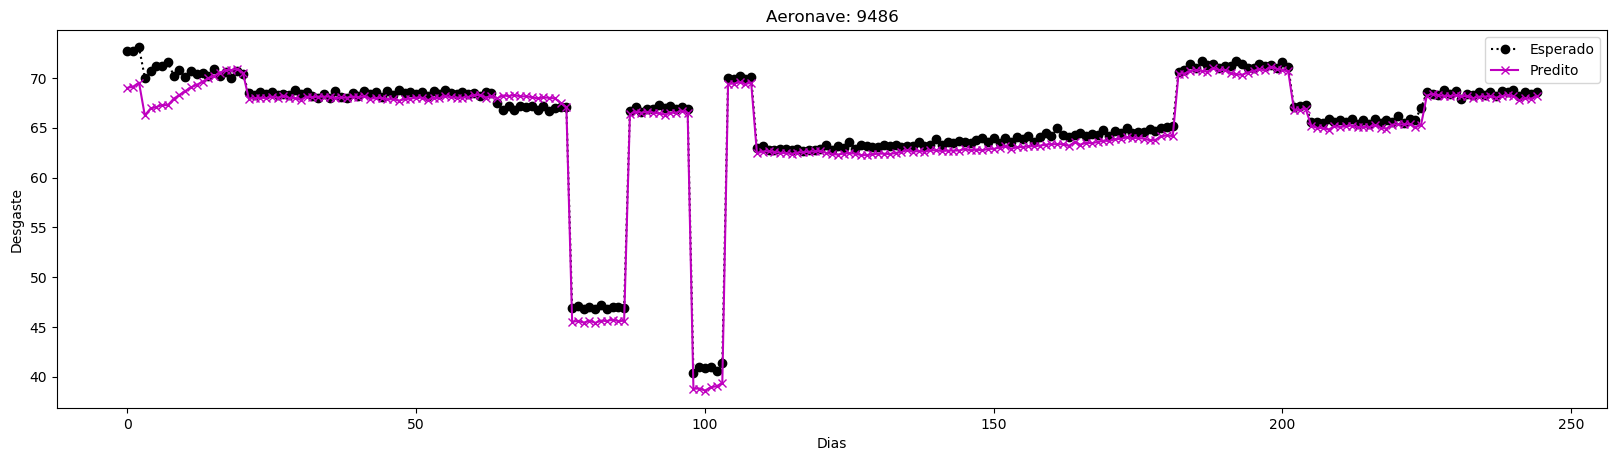

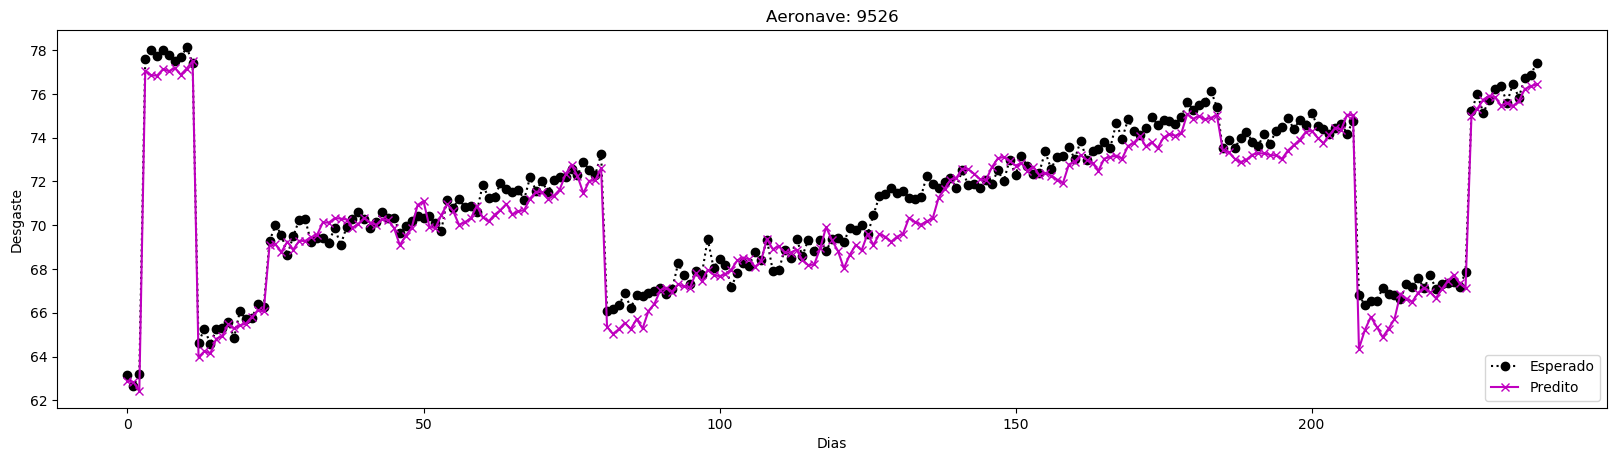

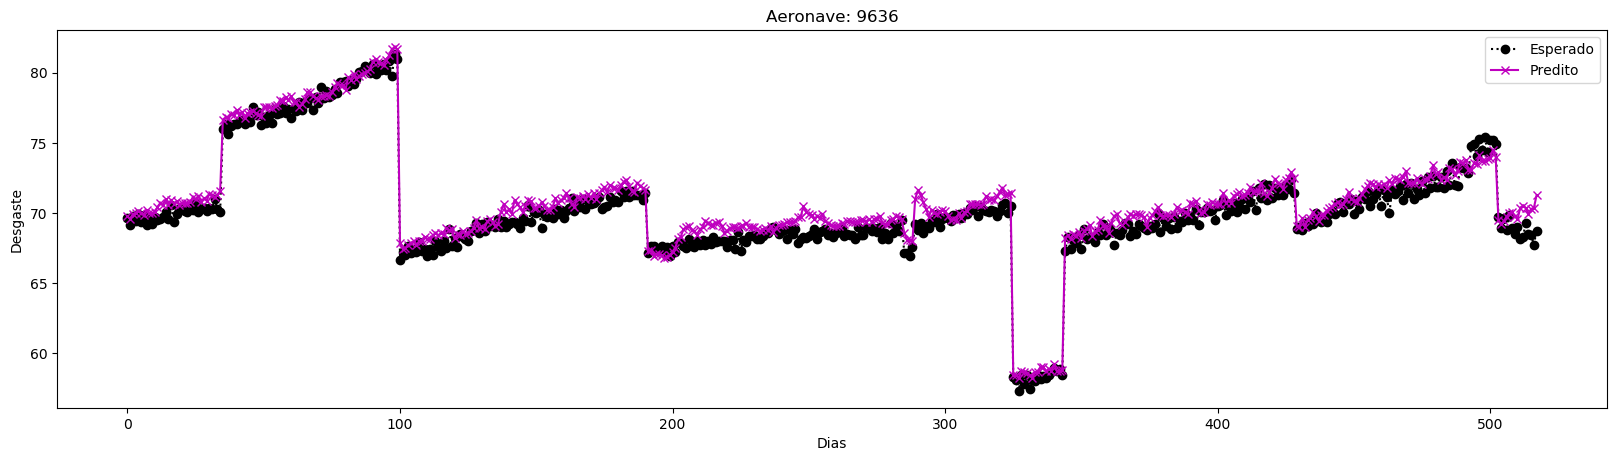

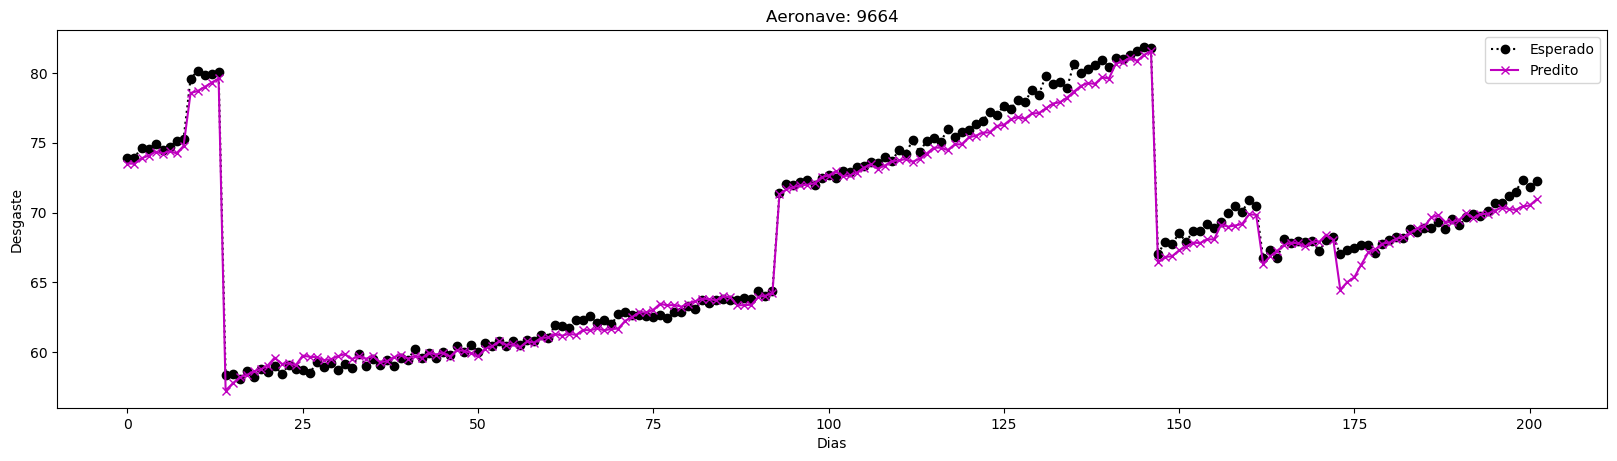

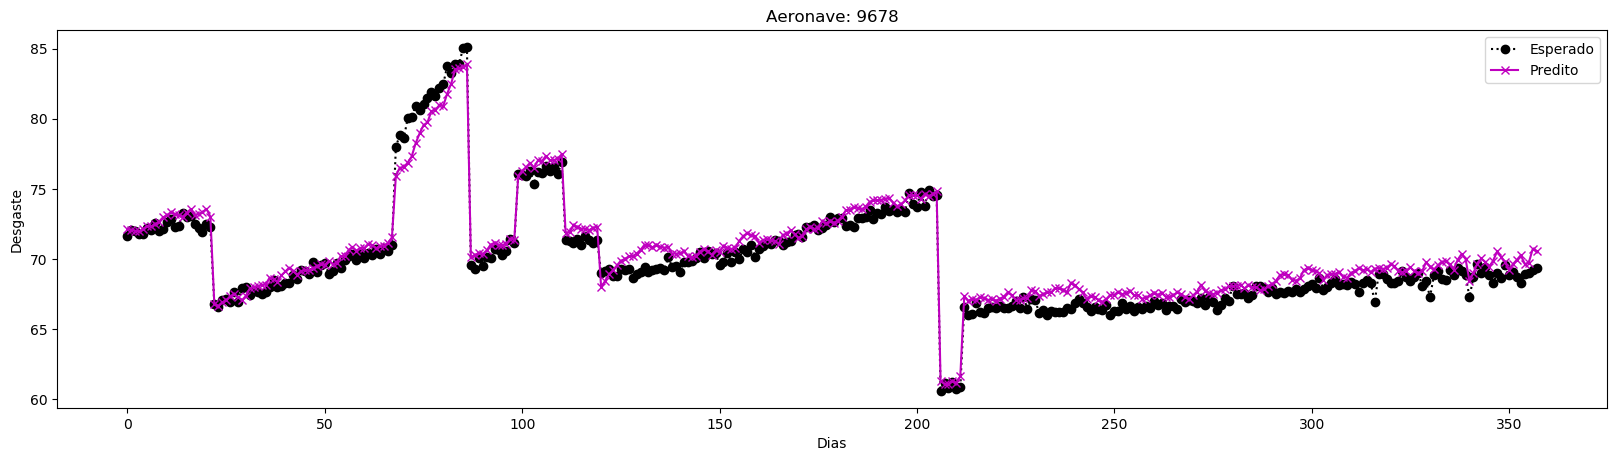

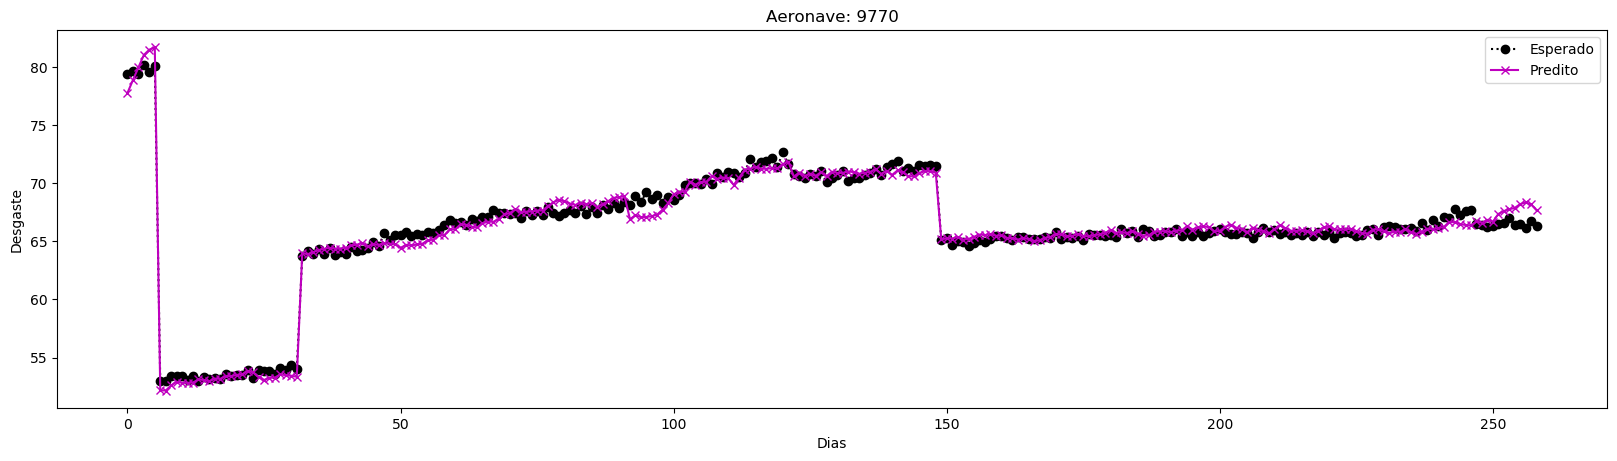

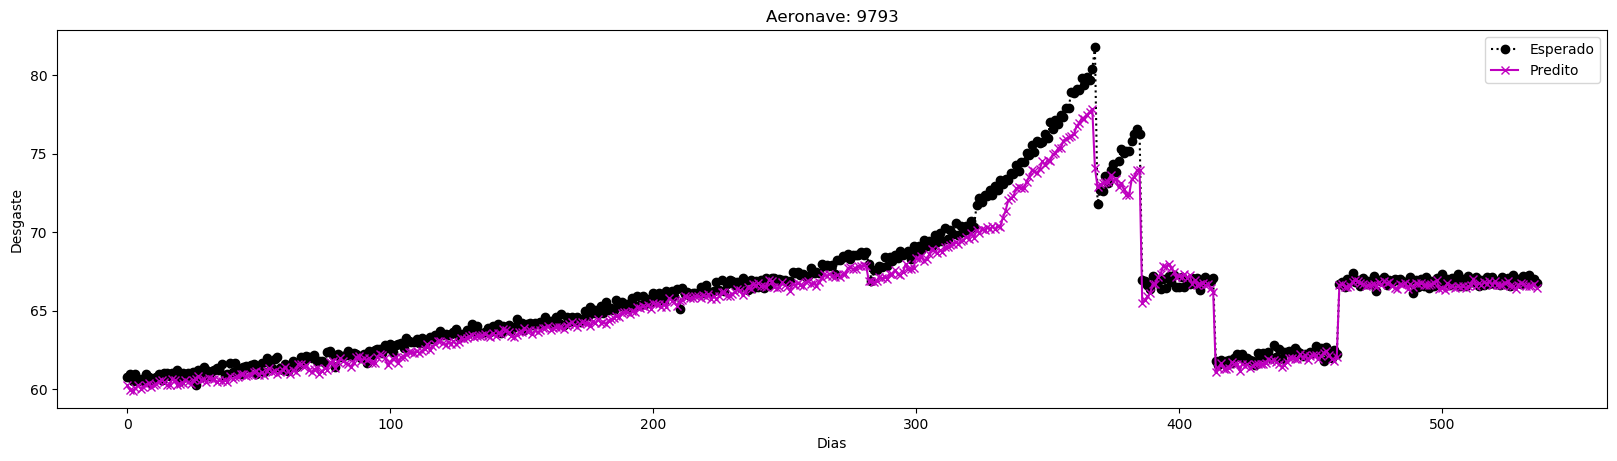

In [15]:
name ="GRU"
falh = 24
look_back = 20
aenvs =np.unique(data_health.COD_AENV)
for k in range(0,8):
  
  
  train_test = model_input(data_health, l_train=look_back,falh = falh)
  tf.random.set_seed(7)
  aenv=aenvs[k]

  trainX, trainY, testX, testY = data_func (train_test, aenv,look_back)

  model = recorrent_model(name=name,units=10,look_back=look_back)
  early_stopping = EarlyStopping(patience=5)
  model.compile(loss='mean_squared_error', val_loss='mean_squared_error', optimizer='adam')
  model.fit(trainX, trainY, epochs=100, batch_size=10, validation_split=0.2, callbacks=[early_stopping], verbose=0)
  plot_results()
  